# Select variables : forecasting of tropical cylone data at 1-day horizon

This notebook accompanies the following publication:
Paul Platzer, Arthur Avenas, Bertrand Chapron, Lucas Drumetz, Alexis Mouche, Léo Vinour. Distance Learning for Analog Methods. 2024. [⟨hal-04841334⟩](https://hal.science/hal-04841334)

It is used to plot the results of optimization algorithms for numerical experiments with IBTrACS tropical cyclone data, at 1-day forecast horizon. The aim is to select the most relevant variables for this forecast and for this particular dataset.

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
import os
import sys
sys.path.append('../../functions/.')
from TC_utils import M, Rmax_from_M, correct_vmx_ibt, Rmxa23

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
cols = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [4]:
data_folder = '../../data/tropical_cyclone/'
output_folder = '../../output/tropical_cyclone/'

# Parameters for loading IBTrACS dataset

In [5]:
files = os.listdir(data_folder)

# Input variables
var_names = ['Vmax', 'Rmax_IBT', 'R34', 'fcor', 'u_trans', 'v_trans']

# Output variable to forecast: derivative of Vmax
var_y = ['Vmax']
dydt = True
ind_var_y = []
for name_tmp in var_y:
    ind_var_y.append(np.argwhere(np.array(var_names)==name_tmp)[0][0])

# Utils to compute Rmax estimate from Avenas et al. (2023)
var_A23 = ['fcor', 'Vmax', 'R34', ]
ind_A23 = []
for name_tmp in var_A23:
    ind_A23.append(np.argwhere(np.array(var_names)==name_tmp)[0][0])

# Add names of auxilliary variables (Rmax_A23 and time-derivatives)
var_names_all = var_names.copy()
var_names_all.append('Rmax_A23')
for name in var_names_all.copy():
    var_names_all.append('d'+name+'/dt')

# Add name of time since the threshold of 18m/s is crossed for Vmax
var_names_all.append('t_18')

# Loading and preprocessing dataset

In [6]:
## Set forecast time-horizon (multiple of 3hours)

h = 8


## Load dataset

IBT = np.array(pandas.read_csv(data_folder + files[0], usecols = var_names))
IBT = np.concatenate( [ IBT , 
         Rmxa23(IBT[:,ind_A23[0]] , IBT[:,ind_A23[1]] , IBT[:,ind_A23[2]]).reshape(-1,1) ,
                      ],  axis=1)
IBT = np.concatenate( ( IBT[1:] , IBT[1:] - IBT[:-1] ) , axis=1 )
IBT = np.concatenate( [ IBT ,
           3*np.arange(len(IBT)).reshape(-1,1) ],  axis=1)
train_x = IBT[0:-h,:]
train_y = IBT[h:,ind_var_y] - IBT[0:-h,ind_var_y] 
ID = np.array([0]*len(IBT[0:-h,:]))


for i in np.arange(1, len(files)):
    IBT = np.array(pandas.read_csv(data_folder + files[i], usecols = var_names))
    IBT = np.concatenate( [ IBT , 
             Rmxa23(IBT[:,ind_A23[0]] , IBT[:,ind_A23[1]] , IBT[:,ind_A23[2]]).reshape(-1,1) ,
                          ],  axis=1)
    IBT = np.concatenate( ( IBT[1:] , IBT[1:] - IBT[:-1] ) , axis=1 )
    IBT = np.concatenate( [ IBT ,
           3*np.arange(len(IBT)).reshape(-1,1) ],  axis=1)
    train_x = np.concatenate([train_x, IBT[0:-h,:]])
    train_y = np.concatenate([train_y, IBT[h:,ind_var_y] - IBT[0:-h,ind_var_y]])
    ID = np.concatenate([ID, np.array([i]*len(IBT[0:-h,:]))])

# center and reduce
mean_IBTrACS = np.mean(train_x, axis=0)
std_IBTrACS = np.std(train_x, axis=0)
mean_y = np.mean(train_y, axis=0)
std_y = np.std(train_y, axis=0)
for j in range(train_x.shape[1]):
    train_x[:,j] = (train_x[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
for j in range(train_y.shape[1]):
    train_y[:,j] = (train_y[:,j] - mean_y[j]) / std_y[j]    

# Loading optimization results

In [7]:
# Load result of gradient-descent optimization
npzfile = np.load(output_folder + 'select_vars_TC_gradient_descent.npz')
var_y = npzfile['var_y']
var_names_all = npzfile['var_names_all']
A_grad = npzfile['A_grad']
E_grad_batch = npzfile['E_grad_batch']
E_grad_train = npzfile['E_grad_train']
E_grad_test = npzfile['E_grad_test']
h = npzfile['h']
k = npzfile['k']
corr_length_train = npzfile['corr_length_train']
learning_rate_factor = npzfile['learning_rate_factor']
Regul = npzfile['Regul']
regul_type = npzfile['regul_type']
random_state_number = npzfile['random_state_number']
Nperm = A_grad.shape[0]

# Load result of iterative grid-search optimization
npzfile = np.load(output_folder + 'select_vars_TC_grid_search.npz')
A_grid = npzfile['A_grid']
E_grid_train = npzfile['E_grid_train']
E_grid_test = npzfile['E_grid_test']

# Preprocessing

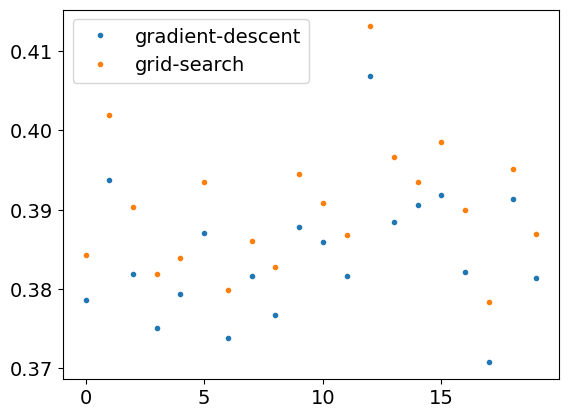

In [8]:
plt.figure()
plt.plot(E_grad_test[:,0,-1], '.', label='gradient-descent')
plt.plot(E_grid_test[:,-1], '.', label='grid-search')
plt.legend()
plt.show()

In [19]:
A_grad.shape, A_grid.shape

((20, 3, 20, 15), (20, 4, 15))

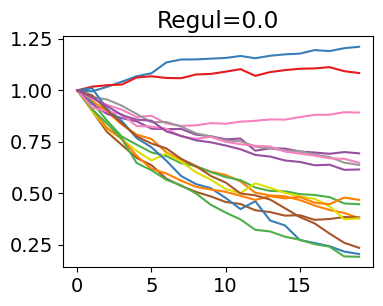

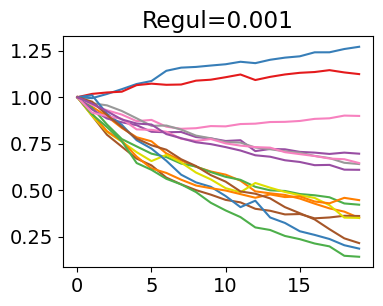

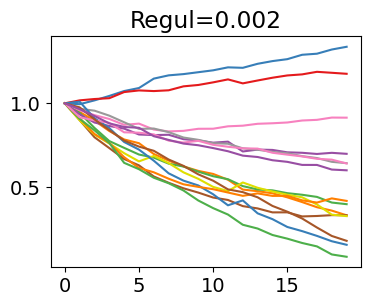

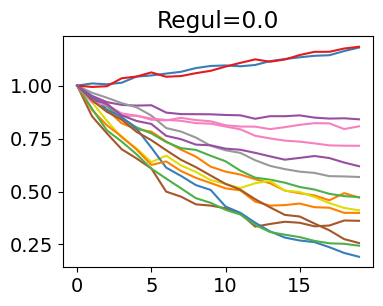

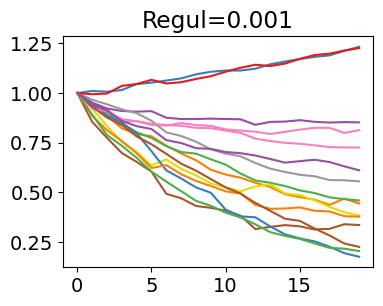

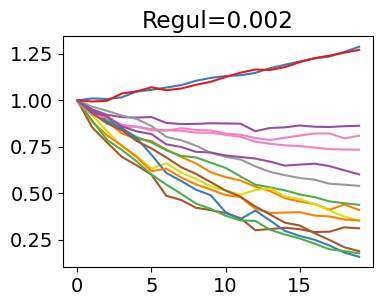

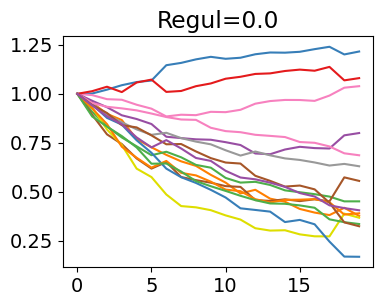

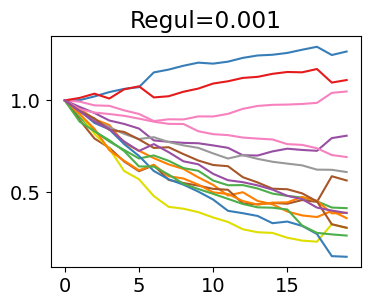

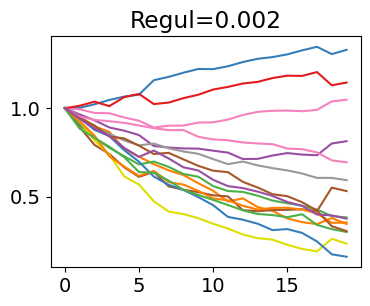

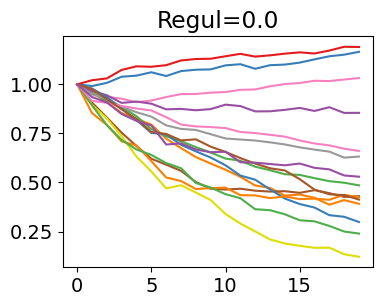

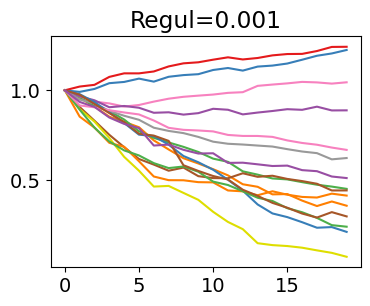

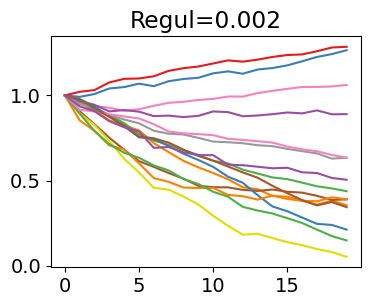

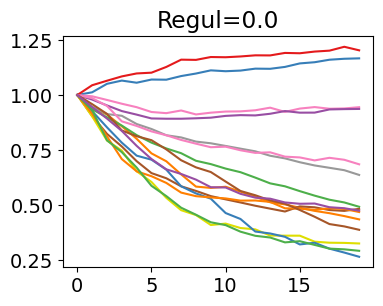

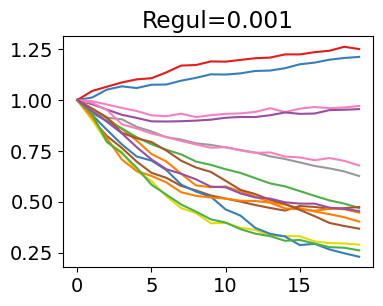

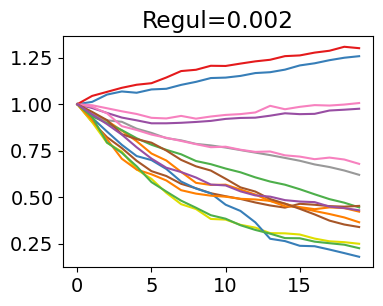

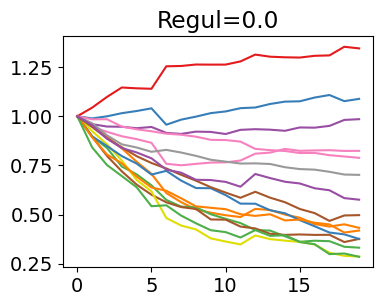

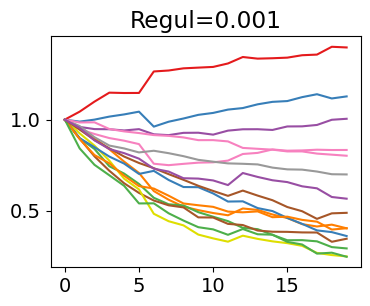

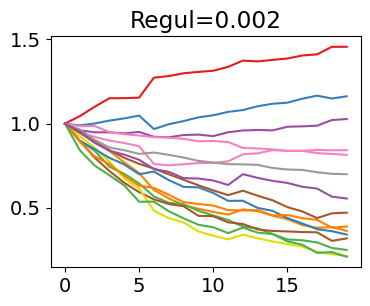

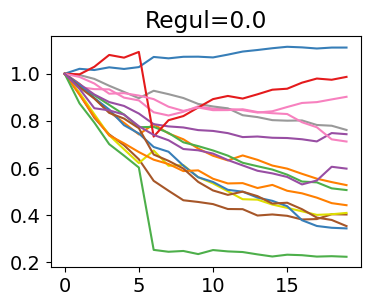

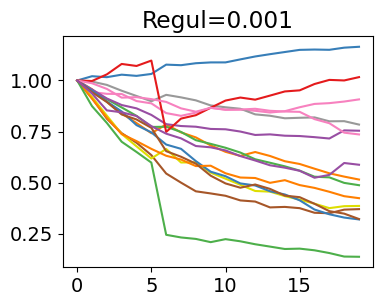

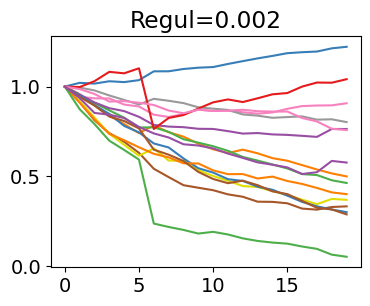

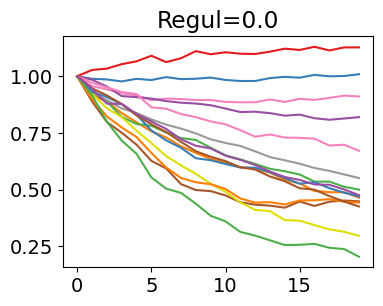

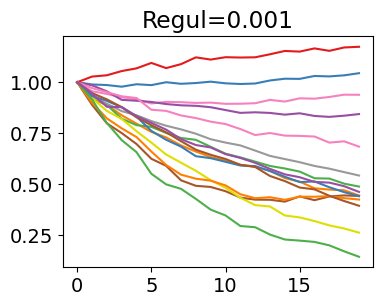

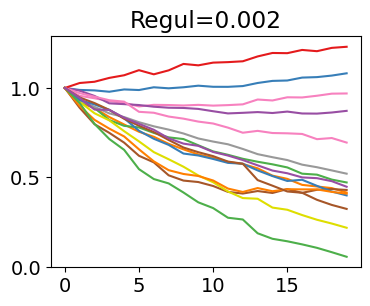

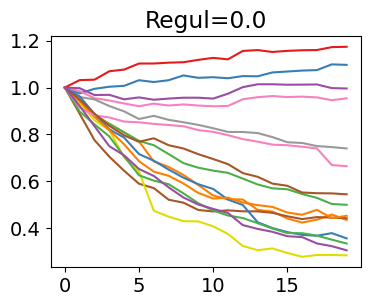

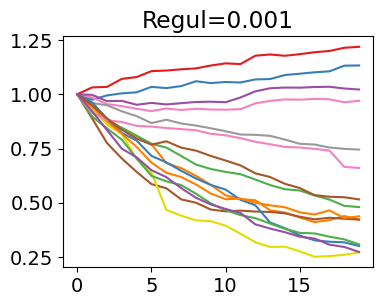

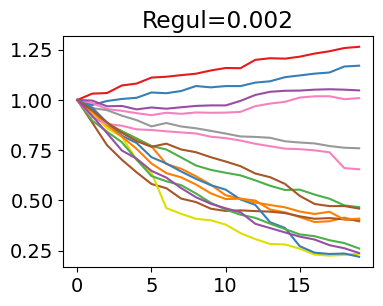

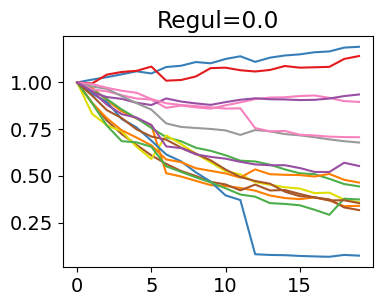

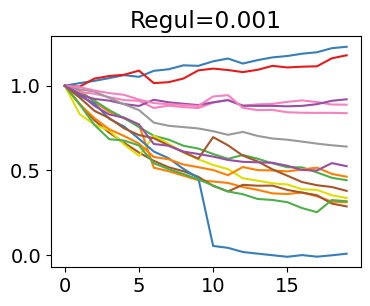

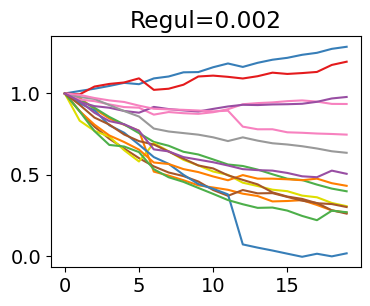

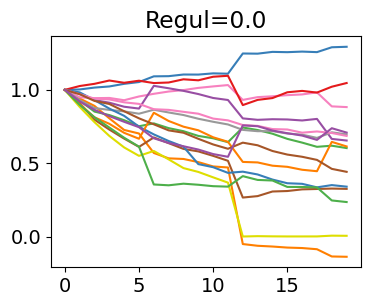

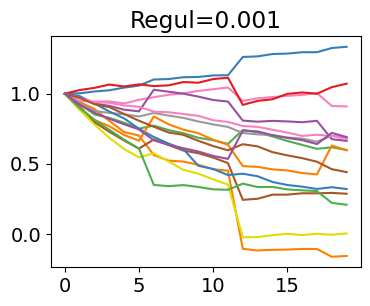

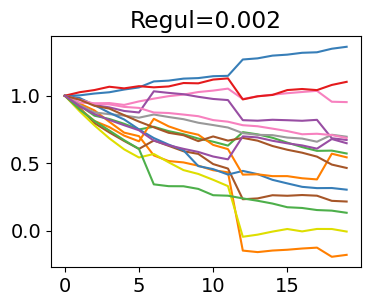

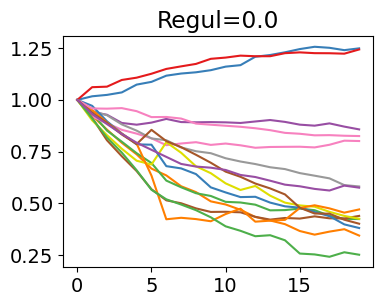

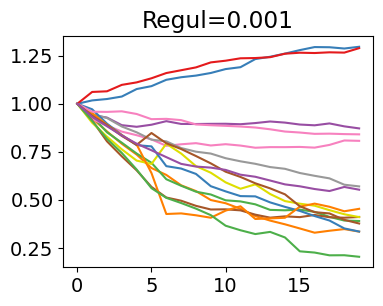

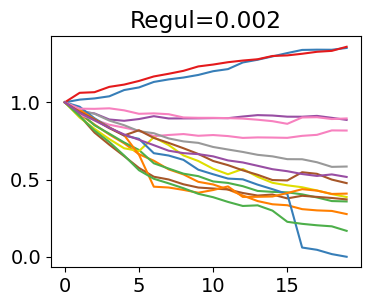

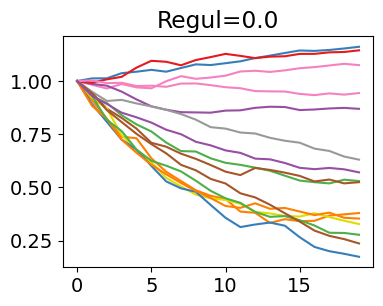

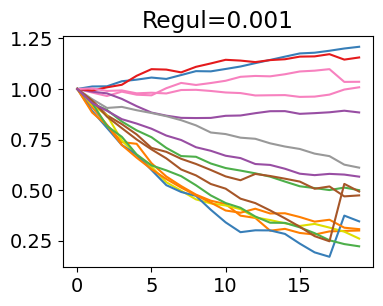

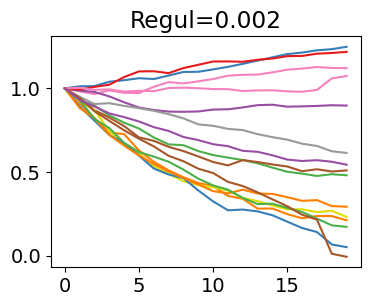

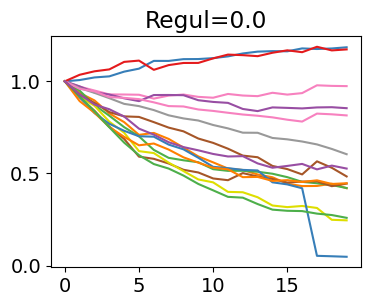

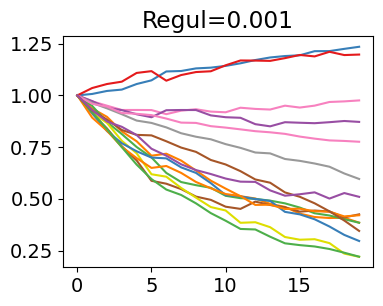

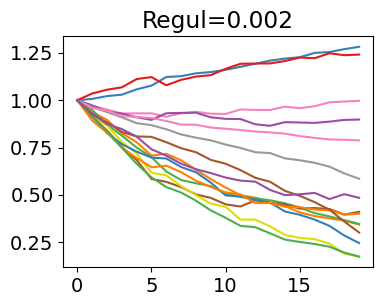

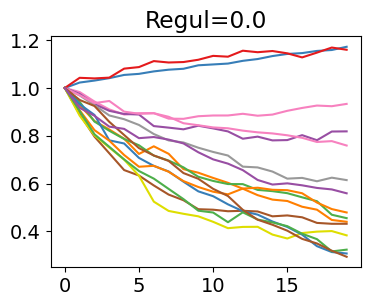

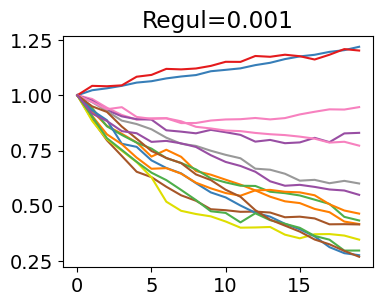

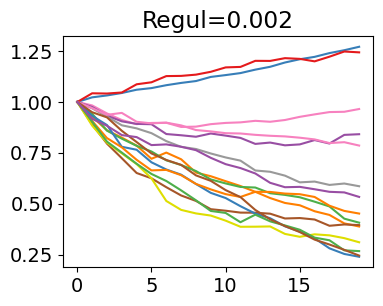

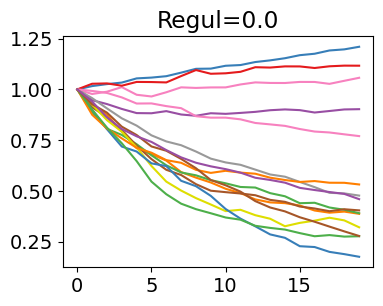

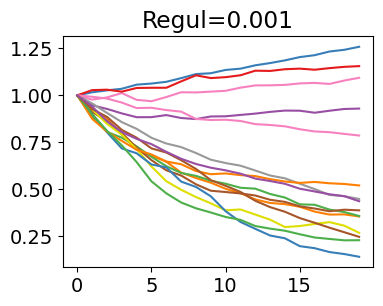

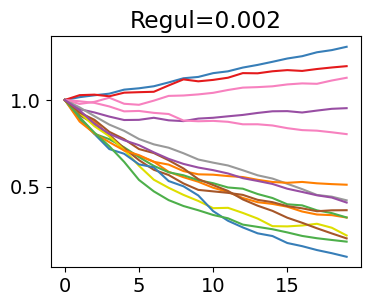

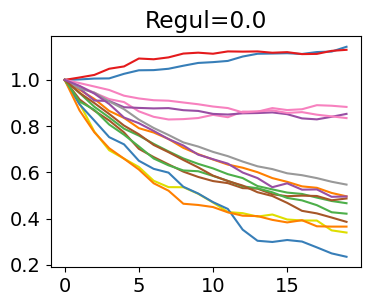

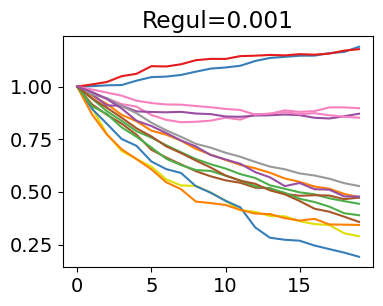

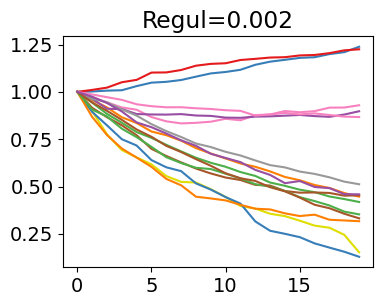

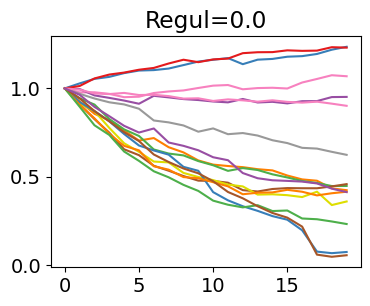

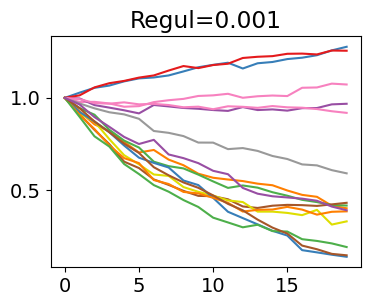

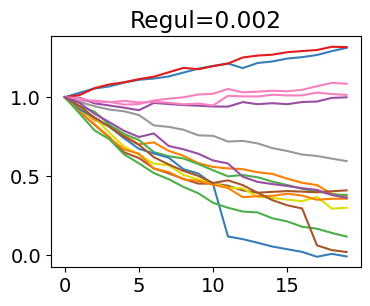

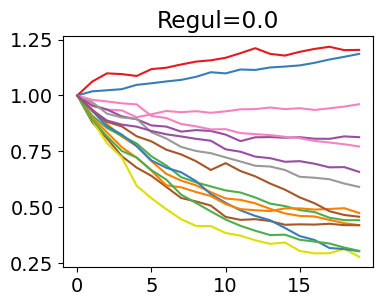

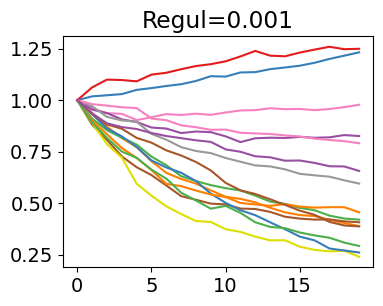

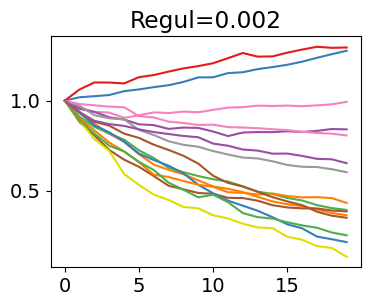

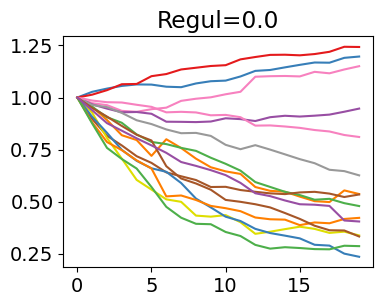

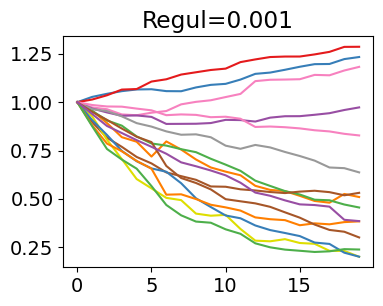

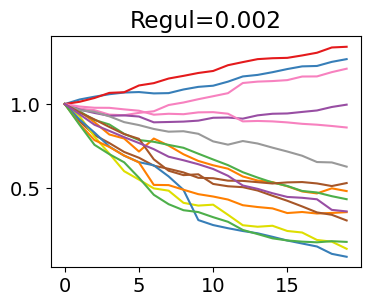

In [24]:
for i_perm in range(Nperm):
    for j_regul in range(len(Regul)):
        plt.figure(figsize=(4,3))
        plt.title('Regul='+str(Regul[j_regul]))
        for k_coef in range(A_grad.shape[-1]):
            plt.plot(A_grad[i_perm,j_regul,:,k_coef], color=(cols*2)[k_coef])
        plt.show()

In [14]:
E_grad_train.shape

(10, 4, 101)

In [17]:
# Set a threshold below which coefficients are considered unsignificant (i.e. almost equal to zero)
thresh = .5
num_coef = np.sum( A_grad>thresh , axis=-1 )

In [18]:
num_coef

array([[[15, 15, 15, ...,  7,  7,  7],
        [15, 15, 15, ...,  7,  7,  7],
        [15, 15, 15, ...,  7,  7,  7]],

       [[15, 15, 15, ...,  7,  7,  7],
        [15, 15, 15, ...,  7,  7,  7],
        [15, 15, 15, ...,  7,  7,  7]],

       [[15, 15, 15, ...,  6,  7,  7],
        [15, 15, 15, ...,  6,  7,  7],
        [15, 15, 15, ...,  6,  7,  7]],

       ...,

       [[15, 15, 15, ...,  6,  6,  6],
        [15, 15, 15, ...,  6,  6,  6],
        [15, 15, 15, ...,  6,  6,  6]],

       [[15, 15, 15, ...,  7,  7,  7],
        [15, 15, 15, ...,  7,  7,  7],
        [15, 15, 15, ...,  7,  7,  7]],

       [[15, 15, 15, ...,  8,  8,  8],
        [15, 15, 15, ...,  7,  8,  8],
        [15, 15, 15, ...,  7,  7,  7]]])

In [13]:
i_perm = 1
np.where(num_coef[i_perm]==3)

(array([], dtype=int64), array([], dtype=int64))

In [12]:
np.argmin(E_grad_train[i_perm][num_coef[i_perm]==3])

IndexError: boolean index did not match indexed array along dimension 1; dimension is 21 but corresponding boolean dimension is 20

In [41]:
E_grad_train[i_perm][num_coef[i_perm]==3].shape

(69,)

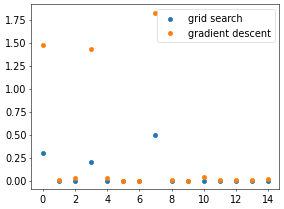

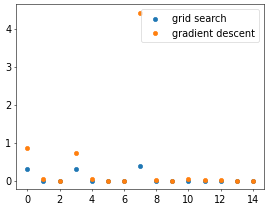

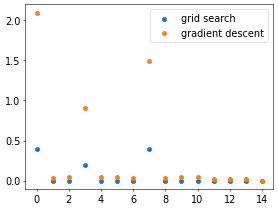

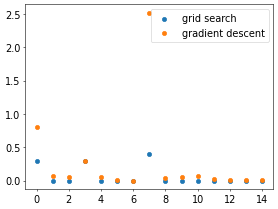

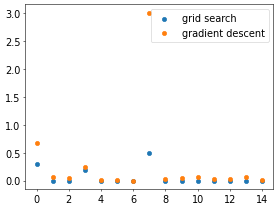

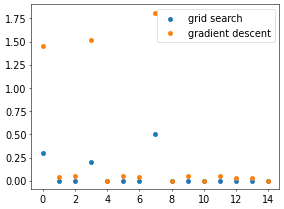

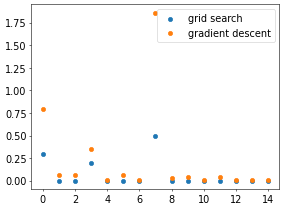

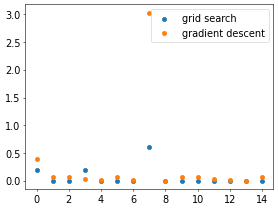

In [52]:
E_grid_train_3var = E_grid_train[:,-1]
E_grid_test_3var = E_grid_test[:,-1]
A_grid_3var = A_grid[:,-1]

E_grad_train_3var = np.full_like(E_grid_train_3var, np.nan)
E_grad_test_3var = np.full_like(E_grid_test_3var, np.nan)
A_grad_3var = np.full_like(A_grid_3var, np.nan)

for i_perm in range(Nperm):
    if np.sum(num_coef[i_perm]==3) != 0:
        # Find indices for which the gradient-descent approach keeps only 3 variables and has minimum training error
        k_lbda = np.where(num_coef[i_perm]==3)[0][np.argmin(E_grad_train[i_perm][num_coef[i_perm]==3])]
        j_iter = np.where(num_coef[i_perm]==3)[1][np.argmin(E_grad_train[i_perm][num_coef[i_perm]==3])]
        
        E_grad_train_3var[i_perm] = E_grad_train[i_perm, k_lbda, j_iter]
        E_grad_test_3var[i_perm] = E_grad_test[i_perm, k_lbda, j_iter]
        A_grad_3var[i_perm] = np.abs(A_grad[i_perm, k_lbda, j_iter]) # convert to absolute values since the sign does not influence the weights
    
        plt.figure(dpi=50)
        plt.scatter( np.arange(train_x.shape[1]) , np.abs(A_grid[i_perm,-1]) , label = 'grid search' )
        plt.scatter( np.arange(train_x.shape[1]) , np.abs(A_grad[i_perm, k_lbda, j_iter]) , label = 'gradient descent' )
        plt.legend()
        plt.show()

In [54]:
E_grad_train_3var, E_grid_train_3var

(array([0.3777563 , 0.37553298, 0.38871995,        nan, 0.42263566,
        0.40349912, 0.39376021, 0.4152403 , 0.42722184,        nan]),
 array([0.38097159, 0.37512649, 0.39037815, 0.39653461, 0.41929492,
        0.3978189 , 0.39719726, 0.41370424, 0.41931081, 0.3906035 ]))

In [55]:
E_grad_test_3var, E_grid_test_3var

(array([0.40029775, 0.41477178, 0.38340705,        nan, 0.32754828,
        0.36492389, 0.36554692, 0.34437697, 0.33703491,        nan]),
 array([0.39648044, 0.41514864, 0.37995137, 0.36562932, 0.33071291,
        0.36520751, 0.36647068, 0.34338099, 0.33142092, 0.37762239]))

In [78]:
nan_condition = np.invert(np.isnan(E_grad_train_3var))

In [80]:
np.mean(E_grad_train_3var[nan_condition]), np.mean(E_grid_train_3var[nan_condition])

(0.4005457961085266, 0.3992252934376669)

In [81]:
np.mean(E_grad_test_3var[nan_condition]), np.mean(E_grid_test_3var[nan_condition])

(0.3672384429189701, 0.3660966807380973)

In [82]:
np.std(E_grad_train_3var[nan_condition]), np.std(E_grid_train_3var[nan_condition])

(0.01855774923005479, 0.015867305181531597)

In [83]:
np.std(E_grad_test_3var[nan_condition]), np.std(E_grid_test_3var[nan_condition])

(0.028792769151683346, 0.028488095999623736)

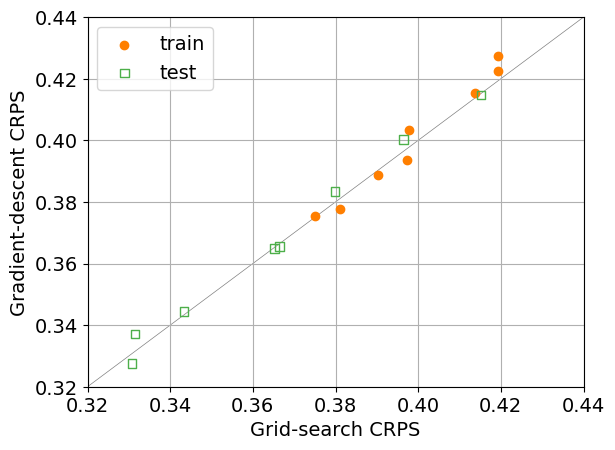

In [102]:
plt.figure()
plt.scatter(E_grid_train_3var[nan_condition], E_grad_train_3var[nan_condition],
            c=cols[1], zorder=10, label='train')
plt.scatter(E_grid_test_3var[nan_condition], E_grad_test_3var[nan_condition],
            edgecolors=cols[2], marker='s', facecolors='none', zorder=10, label='test')
# vmin = 0.37; vmax= 0.43
vmin = 0.32; vmax= 0.44
plt.plot([vmin, vmax], [vmin, vmax], '-', color='0.5', lw=.5, zorder=1)
plt.grid()
plt.legend()
plt.xlim([vmin, vmax])
plt.ylim([vmin, vmax])
plt.xlabel('Grid-search CRPS')
plt.ylabel('Gradient-descent CRPS')
plt.show()

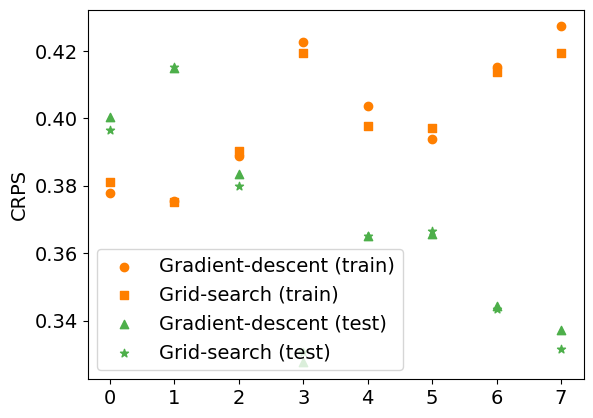

In [87]:
plt.figure()

plt.scatter( np.arange(np.sum(nan_condition)) , E_grad_train_3var[nan_condition] , color=cols[1] , marker='o' , label='Gradient-descent (train)' )
plt.scatter( np.arange(np.sum(nan_condition)) , E_grid_train_3var[nan_condition] , color=cols[1] , marker='s' , label='Grid-search (train)' )

plt.scatter( np.arange(np.sum(nan_condition)) , E_grad_test_3var[nan_condition] , color=cols[2] , marker='^' , label='Gradient-descent (test)' )
plt.scatter( np.arange(np.sum(nan_condition)) , E_grid_test_3var[nan_condition] , color=cols[2] , marker='*' , label='Grid-search (test)' )

plt.ylabel('CRPS')
plt.legend()

plt.show()

In [56]:
ind_best_train = np.argmin(E_grad_train, axis=2, keepdims=True)

In [67]:
np.argmin(E_grad_train, axis=2).shape

(10, 4)

In [63]:
ind_best_train.shape

(10, 4, 1)

In [70]:
ind2_best_train = np.argmin( np.min(E_grad_train, axis=2), axis=1)
ind2_best_train

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [61]:
E_grad_train.shape

(10, 4, 101)

In [72]:
ind2_best_train = np.argmin( np.min(E_grad_train, axis=2), axis=1)

E_grad_train_best = np.full_like(E_grid_train_3var, np.nan)
E_grad_test_best = np.full_like(E_grid_test_3var, np.nan)

for i_perm in range(Nperm):
    E_grad_train_best[i_perm] = np.take_along_axis( E_grad_train , ind_best_train, axis=2)[i_perm][ind2_best_train[i_perm]]
    E_grad_test_best[i_perm] = np.take_along_axis( E_grad_test , ind_best_train, axis=2)[i_perm][ind2_best_train[i_perm]]

/tmp/ipykernel_246512/1011400221.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_grad_train_best[i_perm] = np.take_along_axis( E_grad_train , ind_best_train, axis=2)[i_perm][ind2_best_train[i_perm]]
/tmp/ipykernel_246512/1011400221.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_grad_test_best[i_perm] = np.take_along_axis( E_grad_test , ind_best_train, axis=2)[i_perm][ind2_best_train[i_perm]]


In [73]:
E_grad_train_best, E_grad_test_best

(array([0.37669271, 0.37003413, 0.38708173, 0.39216068, 0.41657152,
        0.39744266, 0.39246201, 0.41081979, 0.41514981, 0.38662898]),
 array([0.40027893, 0.41053434, 0.38393748, 0.37311301, 0.33036076,
        0.3626456 , 0.36617319, 0.34953567, 0.33637593, 0.37913638]))

In [74]:
np.mean(E_grad_train_best), np.mean(E_grid_train_3var)

(0.39450440260970765, 0.3980940453446742)

In [75]:
np.mean(E_grad_test_best), np.mean(E_grid_test_3var)

(0.36920913044346, 0.3672025164464734)

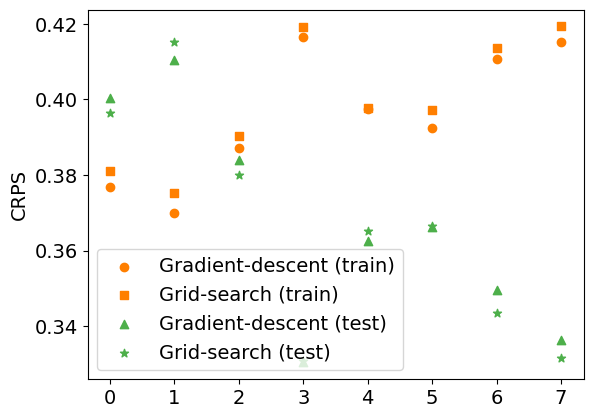

In [88]:
plt.figure()

plt.scatter( np.arange(np.sum(nan_condition)) , E_grad_train_best[nan_condition] , color=cols[1] , marker='o' , label='Gradient-descent (train)' )
plt.scatter( np.arange(np.sum(nan_condition)) , E_grid_train_3var[nan_condition] , color=cols[1] , marker='s' , label='Grid-search (train)' )

plt.scatter( np.arange(np.sum(nan_condition)) , E_grad_test_best[nan_condition] , color=cols[2] , marker='^' , label='Gradient-descent (test)' )
plt.scatter( np.arange(np.sum(nan_condition)) , E_grid_test_3var[nan_condition] , color=cols[2] , marker='*' , label='Grid-search (test)' )

plt.ylabel('CRPS')
plt.legend()

plt.show()

# Plots

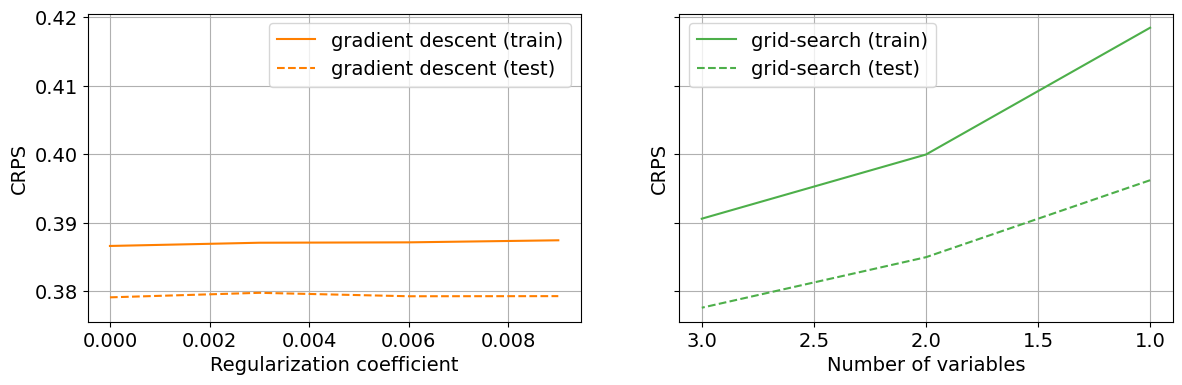

In [21]:
i_perm -= 1
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))

ax1.plot(Regul, np.take_along_axis( E_grad_train , ind_best_train, axis=2)[i_perm], label='gradient descent (train)', color=cols[1])
ax1.plot(Regul, np.take_along_axis( E_grad_test , ind_best_train, axis=2)[i_perm], label='gradient descent (test)', ls='--', color=cols[1])
ax1.legend(); ax1.grid()
ax1.set_ylabel('CRPS')
ax1.set_xlabel('Regularization coefficient')

ax2.plot(np.arange(1,Nvars+1), E_grid_train[i_perm], label='grid-search (train)', ls='-', color=cols[2])
ax2.plot(np.arange(1,Nvars+1), E_grid_test[i_perm], label='grid-search (test)', ls='--', color=cols[2])
ax2.legend(); ax2.grid()
ax2.xaxis.set_inverted(True) 
ax2.set_ylabel('CRPS')
ax2.set_xlabel('Number of variables')

plt.show()


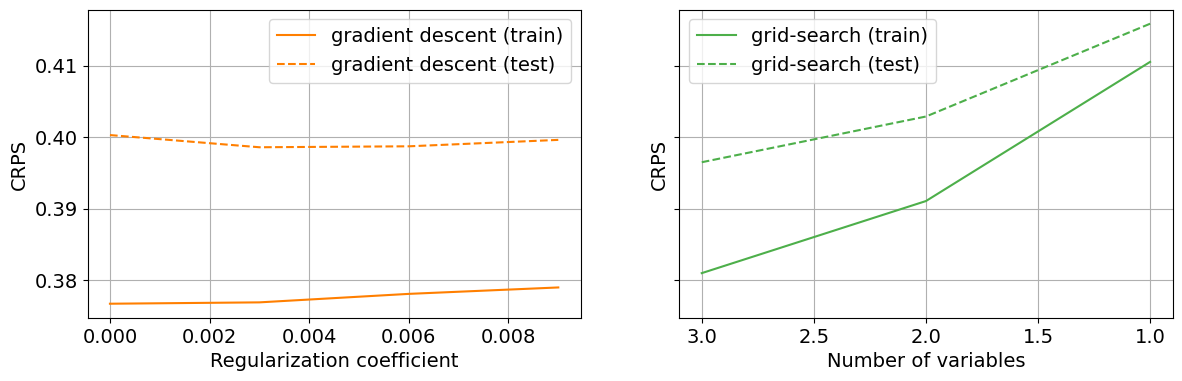

In [65]:
i_perm = 0
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))

ax1.plot(Regul, np.take_along_axis( E_grad_train , ind_best_train, axis=2)[i_perm], label='gradient descent (train)', color=cols[1])
ax1.plot(Regul, np.take_along_axis( E_grad_test , ind_best_train, axis=2)[i_perm], label='gradient descent (test)', ls='--', color=cols[1])
ax1.legend(); ax1.grid()
ax1.set_ylabel('CRPS')
ax1.set_xlabel('Regularization coefficient')

ax2.plot(np.arange(1,Nvars+1), E_grid_train[i_perm], label='grid-search (train)', ls='-', color=cols[2])
ax2.plot(np.arange(1,Nvars+1), E_grid_test[i_perm], label='grid-search (test)', ls='--', color=cols[2])
ax2.legend(); ax2.grid()
ax2.xaxis.set_inverted(True) 
ax2.set_ylabel('CRPS')
ax2.set_xlabel('Number of variables')

plt.show()
